# Detección de fraude
---
Esta parte de la evaluación consiste en realizar un modelo de predicción de fraude.

El set de datos està en `data/fraud/creditcard_train.csv`

La evaluación es tipo *datathon* de forma que las notas se calcularán en base a:

1. Al ranking de métricas de los modelos (80%)
2. Legibilidad y presentación del código (20%)

La forma de entrega será generar un fichero csv en formato a partir de las predicciones realizadas sobre el fichero `data/fraud/creditcard_test.csv`.

| IdObservación | clase_predicha | probabilidad_clase_1 |
| ------------- | ------------- | ------------- |
|00001|True|0.6398|
|00002|True|0.5892|
|00003|False|0.2163|

EL fichero resultante tiene que tener por nombre `inicialapellido_test.csv` y se tiene que enviar por email a:

datathonuib@gmail.com

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis descriptivo básico

### Preparación de los datos

In [2]:
df_train = pd.read_csv('data/fraud/creditcard_train.csv')

In [3]:
df_train.head(5)

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,44.0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,...,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,0.75,0
1,1,56.0,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,...,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,0
2,2,125.0,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,113.00,0
3,3,140.0,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,...,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,1.29,0
4,4,196.0,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,...,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,63.90,0


Eliminamos la columna **Index** pues no ofrece información, además ya la estructura de data frame de **Pandas** ya proporciona dicha información.

In [4]:
df_train = df_train.drop('index', axis = 1)

### Estadísticos básicos del conjunto de datos

In [5]:
df_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,...,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000
mean,94413.335630,-0.192386,0.164128,-0.320883,0.214420,-0.138538,-0.045972,-0.260026,0.020558,-0.101755,...,0.036519,-0.010749,0.005431,-0.010122,0.011992,0.008631,0.010403,0.002055,89.591424,0.047619
std,47090.203021,2.539145,1.976724,2.536887,1.758363,1.861499,1.380380,2.269845,1.890984,1.307423,...,1.134010,0.786006,0.601718,0.598658,0.521701,0.487096,0.471975,0.311344,239.425840,0.212972
min,44.000000,-30.552380,-34.575064,-31.103685,-5.020488,-25.025820,-9.847370,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-15.981649,-2.766638,-3.536716,-1.480189,-7.263482,-5.706918,0.000000,0.000000
25%,54238.500000,-0.989676,-0.583268,-1.090674,-0.780131,-0.749119,-0.803048,-0.623201,-0.201921,-0.694891,...,-0.231617,-0.550772,-0.163394,-0.362282,-0.311030,-0.321798,-0.068158,-0.054186,5.000000,0.000000
50%,84863.500000,-0.023586,0.114158,0.106146,0.063112,-0.070332,-0.292343,0.011035,0.032206,-0.073247,...,-0.022282,0.001268,-0.011584,0.031144,0.031149,-0.044219,0.005249,0.013256,21.230000,0.000000
75%,138697.500000,1.297560,0.888651,0.974192,0.882648,0.598011,0.408838,0.550909,0.358243,0.585619,...,0.206964,0.521199,0.145209,0.422574,0.358695,0.264279,0.108512,0.084301,78.900000,0.000000
max,172786.000000,2.371289,22.057729,4.187811,12.114672,16.625394,14.570654,26.237722,20.007208,6.778615,...,27.202839,8.361985,17.606637,3.633399,3.410742,2.807408,4.347262,9.641075,7541.700000,1.000000


En la tabla anterior, tenemos información como la media, la desviación típica, el valor mínimo, máximo y los cuartiles para tener una primera aproximación sobre los datos que se van a manejar.

### Mapa de calor de correlaciones

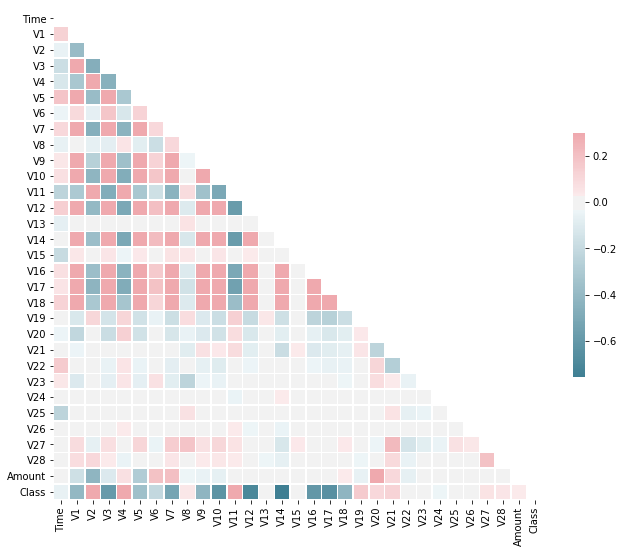

In [6]:
# Getting and showing correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

Como podemos observar del mapa de calor anterior, no existen correlaciones demasiado elevadas entre las variables. De hecho, hay una gran parte de variables que tienen una correlación practicamente nula. 
Debido a ello, no tendría sentido aplicar **Análisis de componentes principales (PCA)** para reducir la dimensionalidad.

In [7]:
class_distribution = df_train['Class'].value_counts()
class_distribution / sum(class_distribution)

0    0.952381
1    0.047619
Name: Class, dtype: float64

Nos encontramos ante un problema desbalanceado, ya que solo un ~5% de los datos pertenecen a la clase que queremos predecir.

# Modelización de los datos

En este punto, utilizaremos una serie de modelos estadísticos donde a la postre los compararemos mediante una serie de métricas tales como **AUC** o **ROC** que nos permitirán escoger el mejor modelo.

Debido a que disponemos un conjunto de datos de prueba que no contiene el valor real de la variable respuesta, utilizaremos el conjunto de entrenamiento para realizar las pruebas en primera instancia y obtener una aproximación del error.

Una vez elegido el mejor modelo, utilizaremos el conjunto de prueba real sobre el que deseamos realizar la predicción.

Los modelos elegidos son:

* Regresión logística
* Random Forest
* Boosting

Al trabajar con datos desbalanceados se tendrán que aplicar algunas correcciones para los métodos de regresión logística y de random forest, pero esto no será necesario para Boosting ya que por su propia naturaleza funciona bien en estos casos.

### Regresión Logística

In [8]:
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.metrics         import *

In [37]:
rnd_seed = 123

df = df_train
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), 
                                                    df.Class, 
                                                    test_size=0.1, 
                                                    random_state=rnd_seed)
kfold = StratifiedKFold(n_splits=30, random_state=rnd_seed)
logreg = LogisticRegression(random_state=rnd_seed, class_weight='balanced')
y_pred = cross_val_predict(logreg, X_train, y_train, cv=kfold)

Es importante especificar el argumento `class_weight='balanced'` para que la librería se encargue de ajustar el peso de las clases de forma inversamente proporcional a `n_samples / (n_classes * np.bincount(y))`.

Como cosecuencia, nuestro modelo tendrá un _accuracy_ menor, pero va a mejorar su predicción fuera de la muestra.

In [39]:
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.98      0.99      7090
          1       0.65      0.90      0.76       356

avg / total       0.98      0.97      0.97      7446



Usando el conjunto de test que hemos creado (`X_test` y `y_test`) vamos a simular la precisión que tendría nuestro modelo fuera de la muestra:

Text(0.5,0,'Threshold')

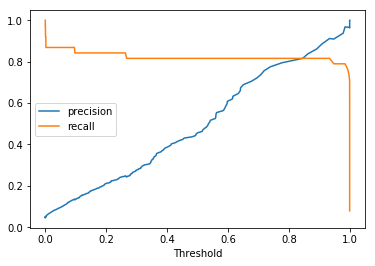

In [41]:
y_proba = cross_val_predict(logreg, X_test, y_test, cv=kfold, method='predict_proba')

prec, rec, thre = precision_recall_curve(y_true=y_test, probas_pred=y_proba[:,1])

plt.plot(thre, prec[:-1], label='precision')
plt.plot(thre, rec[:-1], label='recall')
plt.legend(loc='best')
plt.xlabel('Threshold')

Text(0.5,1,'Precision-Recall curve')

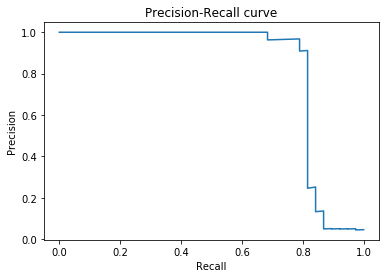

In [32]:
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

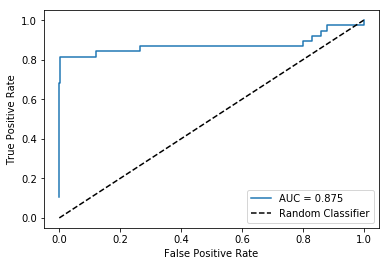

In [36]:
fpr, tpr, thre = roc_curve(y_test, y_proba[:,1])
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

plt.plot(fpr, tpr, label='AUC = {a}'.format(a=round(roc_auc, 3)))
plt.plot([0, 1], '--', c='black', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')